<center><h1>Xian_Junyan_HW8</h1></center>

Name: Junyan Xian 
<br>
Github Username: JunyanXian97
<br>
USC ID: 5625653569

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, confusion_matrix, auc)

#print(os.getcwd())

/Users/apple/Desktop/notebook


### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [3]:
columns = [
    "ID", "Diagnosis", 
    "Mean Radius", "Mean Texture", "Mean Perimeter", "Mean Area", "Mean Smoothness",
    "Mean Compactness", "Mean Concavity", "Mean Concave Points", "Mean Symmetry", "Mean Fractal Dimension",
    "Radius SE", "Texture SE", "Perimeter SE", "Area SE", "Smoothness SE",
    "Compactness SE", "Concavity SE", "Concave Points SE", "Symmetry SE", "Fractal Dimension SE",
    "Worst Radius", "Worst Texture", "Worst Perimeter", "Worst Area", "Worst Smoothness",
    "Worst Compactness", "Worst Concavity", "Worst Concave Points", "Worst Symmetry", "Worst Fractal Dimension"
]

file_path = '/Users/apple/Desktop/data/wdbc.data' 
data = pd.read_csv(file_path, header=None, names=columns)

print(data.head())



         ID Diagnosis  Mean Radius  Mean Texture  Mean Perimeter  Mean Area  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   Mean Smoothness  Mean Compactness  Mean Concavity  Mean Concave Points  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  Worst Radius  Worst Texture  Worst Perimeter  Worst Ar

### (b) Monte-Carlo Simulation

#### (i) Supervised Learning

Average Metrics (Train):
accuracy     0.986813
precision    0.993976
recall       0.970588
f1           0.982143
auc          0.997626
dtype: float64
Average Metrics (Test):
accuracy     0.973684
precision    1.000000
recall       0.928571
f1           0.962963
auc          0.996693
dtype: float64


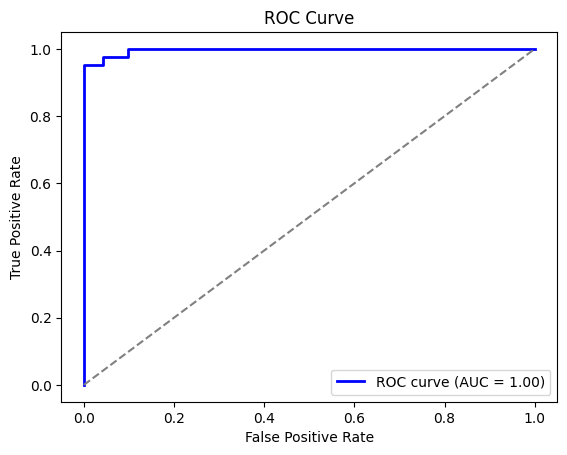

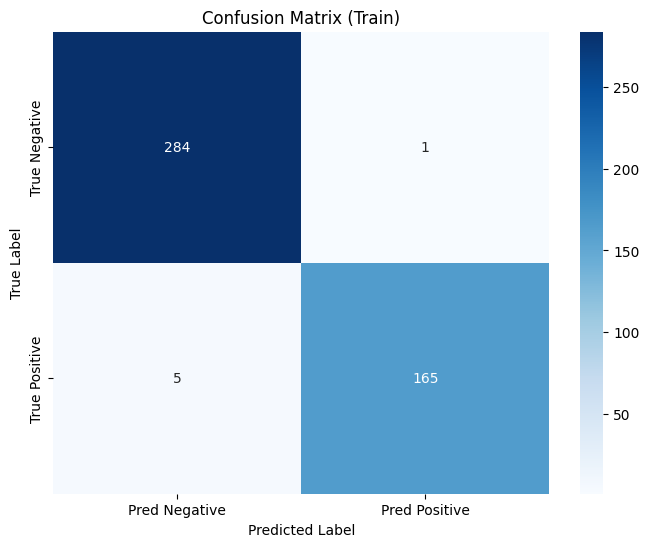

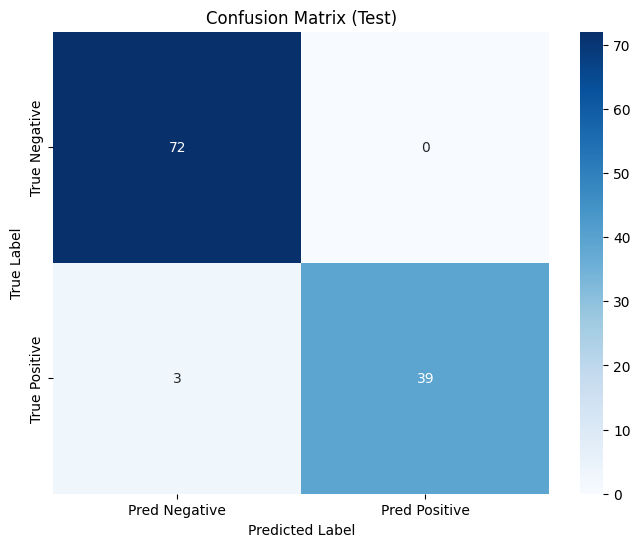

In [5]:
X = data.drop(columns=["Diagnosis", "ID"])  
#print(X.head())
y = data["Diagnosis"]
#print(y.head())
y_numeric = y.map({'B': 0, 'M': 1})
y_numeric_df = y_numeric.to_frame()
#print(y_numeric_df.head())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


metrics = {"train": [], "test": []}

for _ in range(30):

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_numeric, test_size=0.2, stratify=y_numeric, random_state=np.random.randint(1000)
    )

param_grid = {"C": [0.01, 0.1, 1, 10, 100]} 
svm = LinearSVC(penalty="l1", dual=False, max_iter=50000)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

for split, y_true, y_pred in [("train", y_train, y_train_pred), ("test", y_test, y_test_pred)]:
    metrics[split].append({
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, best_model.decision_function(X_test if split == "test" else X_train)),
    })



metrics_train = pd.DataFrame(metrics["train"])
metrics_test = pd.DataFrame(metrics["test"])


avg_metrics_train = metrics_train.mean()
avg_metrics_test = metrics_test.mean()

print("Average Metrics (Train):")
print(avg_metrics_train)

print("Average Metrics (Test):")
print(avg_metrics_test)

fpr, tpr, _ = roc_curve(y_test, best_model.decision_function(X_test))
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix (Train)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

In [7]:
X = data.drop(columns=["Diagnosis", "ID"])  
y = data["Diagnosis"]  
y_numeric = y.map({'B': 0, 'M': 1}) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

best_C_values = []

metrics = {"train": [], "test": []}

for _ in range(30):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_numeric, test_size=0.2, stratify=y_numeric, random_state=np.random.randint(1000)
    )
    positive_class = y_train == 1
    negative_class = y_train == 0

    labeled_positive = np.random.choice(np.where(positive_class)[0], size=int(0.5 * np.sum(positive_class)), replace=False)
    labeled_negative = np.random.choice(np.where(negative_class)[0], size=int(0.5 * np.sum(negative_class)), replace=False)

    labeled_indices = np.concatenate([labeled_positive, labeled_negative])
    X_labeled = X_train[labeled_indices]
    y_labeled = y_train.iloc[labeled_indices]

    param_grid = {"C": [0.01, 0.1, 1, 10, 100]}  
    svm = LinearSVC(penalty="l1", dual=False, max_iter=50000)  

    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="f1")
    grid_search.fit(X_labeled, y_labeled)

    best_C = grid_search.best_params_["C"]
    best_C_values.append(best_C)  

print(f"Best C values from each iteration: {best_C_values}")


Best C values from each iteration: [0.1, 0.1, 100, 0.1, 1, 0.1, 0.1, 100, 0.1, 10, 0.1, 1, 1, 0.1, 10, 0.1, 10, 1, 0.1, 0.1, 0.1, 100, 0.1, 0.1, 0.1, 1, 0.1, 0.1, 10, 1]


##### (B)

Average Metrics (Train) after 30 runs:
accuracy     0.978022
precision    0.981928
recall       0.958824
f1           0.970238
auc          0.997293
dtype: float64

Average Metrics (Test) after 30 runs:
accuracy     0.973684
precision    1.000000
recall       0.928571
f1           0.962963
auc          0.987765
dtype: float64


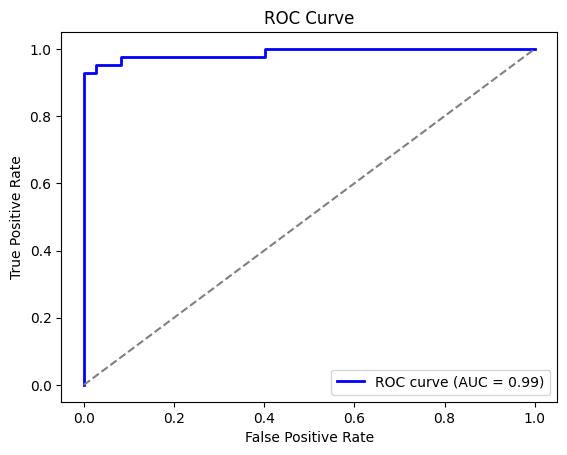

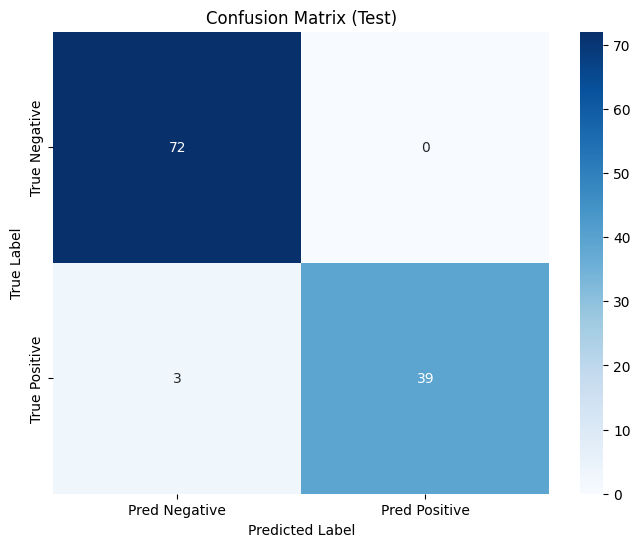

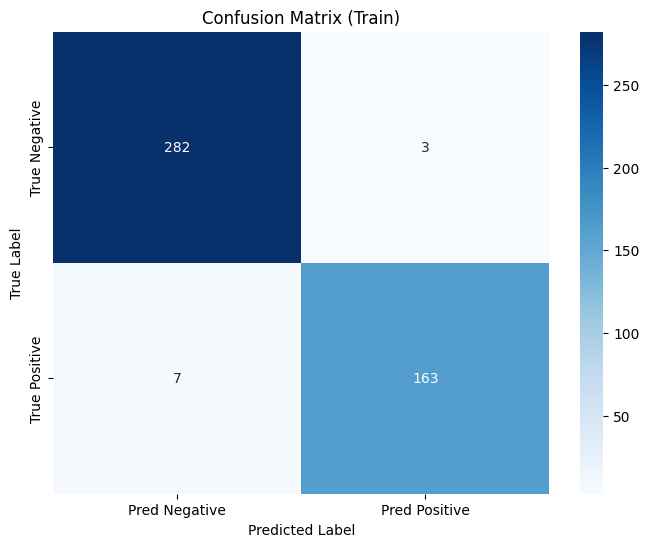

In [11]:
X = data.drop(columns=["Diagnosis", "ID"])  
y = data["Diagnosis"]
y_numeric = y.map({'B': 0, 'M': 1})
y_numeric_df = y_numeric.to_frame()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_numeric, test_size=0.2, stratify=y_numeric, random_state=np.random.randint(1000)
)

positive_class = y_train == 1
negative_class = y_train == 0

labeled_positive = np.random.choice(np.where(positive_class)[0], size=int(0.5 * np.sum(positive_class)), replace=False)
labeled_negative = np.random.choice(np.where(negative_class)[0], size=int(0.5 * np.sum(negative_class)), replace=False)

labeled_indices = np.concatenate([labeled_positive, labeled_negative])
X_labeled = X_train[labeled_indices]
y_labeled = y_train.iloc[labeled_indices]

unlabeled_indices = np.setdiff1d(np.arange(len(X_train)), labeled_indices)
X_unlabeled = X_train[unlabeled_indices]
y_unlabeled = y_train.iloc[unlabeled_indices]

svm = LinearSVC(penalty="l1", dual=False, max_iter=50000)

while len(X_unlabeled) > 0:
    
    svm.fit(X_labeled, y_labeled)
    
    distances = np.abs(svm.decision_function(X_unlabeled)) 
    farthest_index = np.argmax(distances)  
    new_point = X_unlabeled[farthest_index]  
    predicted_label = svm.predict([new_point])[0]  
    
    X_labeled = np.vstack([X_labeled, new_point])
    y_labeled = np.append(y_labeled, predicted_label)
    
    X_unlabeled = np.delete(X_unlabeled, farthest_index, axis=0)
    y_unlabeled = np.delete(y_unlabeled, farthest_index)

metrics_train = []
metrics_test = []

for _ in range(30):

    svm.fit(X_labeled, y_labeled)
    
    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)

    metrics_train.append({
        "accuracy": accuracy_score(y_train, y_train_pred),
        "precision": precision_score(y_train, y_train_pred),
        "recall": recall_score(y_train, y_train_pred),
        "f1": f1_score(y_train, y_train_pred),
        "auc": roc_auc_score(y_train, svm.decision_function(X_train)),
    })

    metrics_test.append({
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "recall": recall_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),
        "auc": roc_auc_score(y_test, svm.decision_function(X_test)),
    })

avg_metrics_train = pd.DataFrame(metrics_train).mean()
avg_metrics_test = pd.DataFrame(metrics_test).mean()

print("Average Metrics (Train) after 30 runs:")
print(avg_metrics_train)

print("\nAverage Metrics (Test) after 30 runs:")
print(avg_metrics_test)

fpr, tpr, _ = roc_curve(y_test, svm.decision_function(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], 
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


cm_train = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], 
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix (Train)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#### (iii) Unsupervised Learning

##### (A)

We can do multiple random initializations to make sure that the algorithm was not trapped in a local minimum. Many same results are likely to indicate a global optimum.

In [39]:
X = data.drop(columns=["Diagnosis", "ID"]) 
y = data["Diagnosis"]
y_numeric = y.map({'B': 0, 'M': 1}) 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42
)

results = [] 
for i in range(30):

    kmeans = KMeans(n_clusters=2, random_state=np.random.randint(1000)) 
    kmeans.fit(X_train)
    results.append({
        "iteration": i + 1,
        "inertia": kmeans.inertia_,  
        "centers": kmeans.cluster_centers_,
        "labels": kmeans.labels_
    })

for res in results:
    print(f"Iteration {res['iteration']}: Inertia = {res['inertia']}")


Iteration 1: Inertia = 9478.26199009714
Iteration 2: Inertia = 9478.317187580999
Iteration 3: Inertia = 9478.744698930626
Iteration 4: Inertia = 9478.386244567344
Iteration 5: Inertia = 9478.26199009714
Iteration 6: Inertia = 9478.733653971129
Iteration 7: Inertia = 9478.317187580999
Iteration 8: Inertia = 9478.26199009714
Iteration 9: Inertia = 9478.317187580999
Iteration 10: Inertia = 9478.26199009714
Iteration 11: Inertia = 9478.26199009714
Iteration 12: Inertia = 9478.26199009714
Iteration 13: Inertia = 9478.26199009714
Iteration 14: Inertia = 9478.908208569414
Iteration 15: Inertia = 9478.26199009714
Iteration 16: Inertia = 9478.26199009714
Iteration 17: Inertia = 9478.317187580997
Iteration 18: Inertia = 9478.26199009714
Iteration 19: Inertia = 9478.317187580997
Iteration 20: Inertia = 9478.26199009714
Iteration 21: Inertia = 9478.317187580997
Iteration 22: Inertia = 9478.031887624176
Iteration 23: Inertia = 9478.317187580997
Iteration 24: Inertia = 9478.26199009714
Iteration 25:

##### (B)

Average Metrics (Train) after 30 runs:
accuracy     0.909231
precision    0.915183
recall       0.834510
f1           0.872931
auc          0.751667
dtype: float64


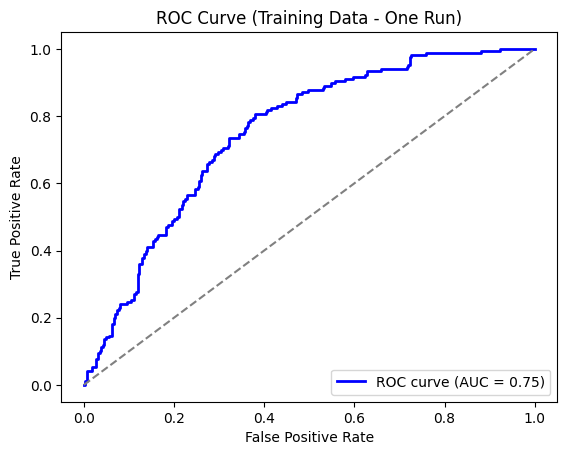

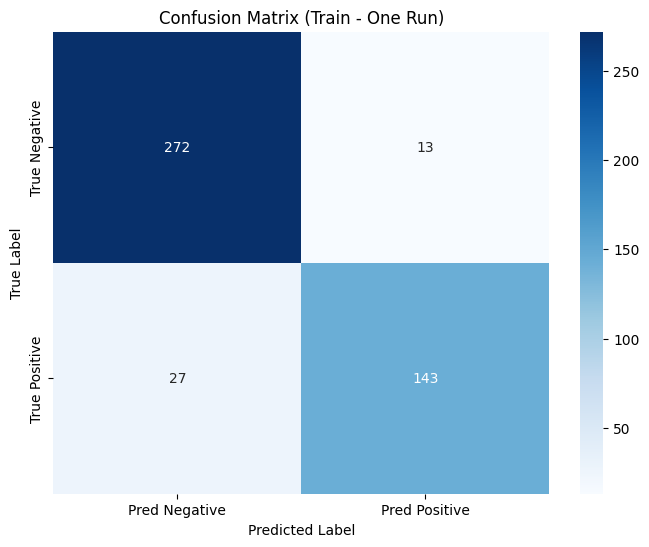

In [57]:
X = data.drop(columns=["Diagnosis", "ID"]) 
y = data["Diagnosis"]
y_numeric = y.map({'B': 0, 'M': 1}) 


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42)


M = 30
metrics_train = []

for _ in range(M):

    kmeans = KMeans(n_clusters=2, random_state=None)
    kmeans.fit(X_train)
    
    cluster_centers = kmeans.cluster_centers_

    closest_30_points_per_cluster = {0: [], 1: []}
    for i, center in enumerate(cluster_centers):
        distances = np.linalg.norm(X_train - center, axis=1)
        closest_indices = np.argsort(distances)[:30]
        closest_30_points_per_cluster[i] = closest_indices


    cluster_labels = np.zeros(2)
    for i in range(2):  
        true_labels = y_train.iloc[closest_30_points_per_cluster[i]].values
        counts = np.bincount(true_labels) 
        cluster_labels[i] = np.argmax(counts)

    y_pred_train = np.zeros(len(y_train))
    for i in range(2):
        y_pred_train[kmeans.labels_ == i] = cluster_labels[i]

    metrics_train.append({
        "accuracy": accuracy_score(y_train, y_pred_train),
        "precision": precision_score(y_train, y_pred_train),
        "recall": recall_score(y_train, y_pred_train),
        "f1": f1_score(y_train, y_pred_train),
        "auc": roc_auc_score(y_train, kmeans.transform(X_train).min(axis=1)),
    })

avg_metrics_train = pd.DataFrame(metrics_train).mean()
print("Average Metrics (Train) after 30 runs:")
print(avg_metrics_train)


selected_run = 0 
y_pred_train_selected = np.zeros(len(y_train))
for i in range(2):
    y_pred_train_selected[kmeans.labels_ == i] = cluster_labels[i]


fpr, tpr, _ = roc_curve(y_train, kmeans.transform(X_train).min(axis=1)) 
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Training Data - One Run)')
plt.legend(loc='lower right')
plt.show()


cm_train = confusion_matrix(y_train, y_pred_train_selected)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], 
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix (Train - One Run)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


##### (C)

Average Metrics (Test) after 30 runs:
accuracy     0.900585
precision    0.934127
recall       0.785714
f1           0.853480
auc          0.693320
dtype: float64


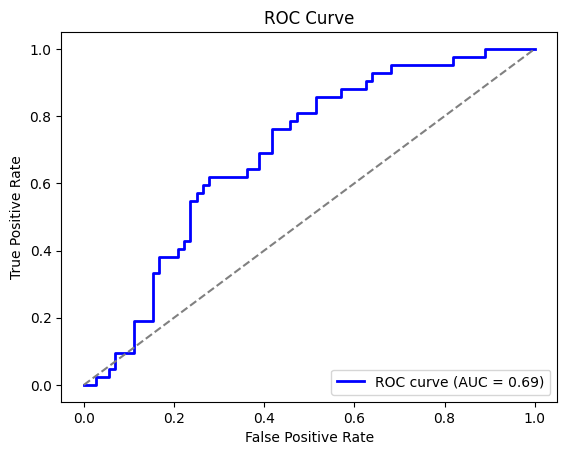

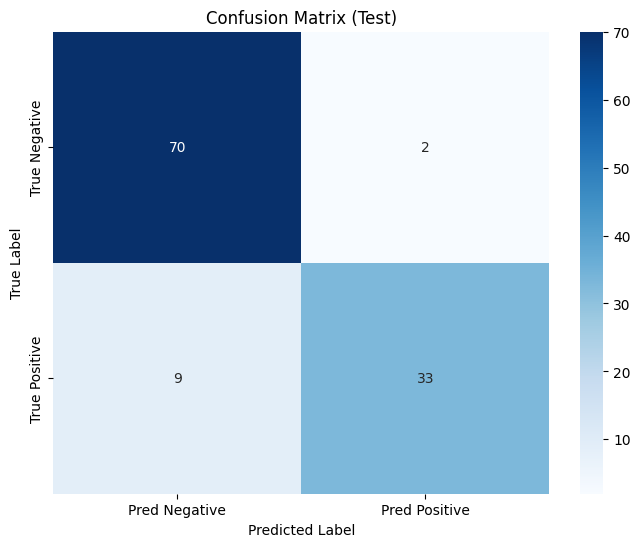

In [50]:
X = data.drop(columns=["Diagnosis", "ID"]) 
y = data["Diagnosis"]
y_numeric = y.map({'B': 0, 'M': 1}) 


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42)

M = 30

metrics_test = []

for _ in range(M):

    kmeans = KMeans(n_clusters=2, random_state=None) 
    kmeans.fit(X_train)

  
    distances = kmeans.transform(X_test)
    y_pred_test = np.argmin(distances, axis=1) 
    
  
    cluster_labels = np.zeros(2)
    for i in range(2):
        true_labels = y_train.iloc[kmeans.labels_ == i].values
        counts = np.bincount(true_labels) 
        cluster_labels[i] = np.argmax(counts)
    
 
    y_pred_test_final = np.array([cluster_labels[i] for i in y_pred_test])

    metrics_test.append({
        "accuracy": accuracy_score(y_test, y_pred_test_final),
        "precision": precision_score(y_test, y_pred_test_final),
        "recall": recall_score(y_test, y_pred_test_final),
        "f1": f1_score(y_test, y_pred_test_final),
        "auc": roc_auc_score(y_test, distances.min(axis=1)),  
    })


avg_metrics_test = pd.DataFrame(metrics_test).mean()
print("Average Metrics (Test) after 30 runs:")
print(avg_metrics_test)

fpr, tpr, _ = roc_curve(y_test, distances.min(axis=1)) 
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

cm_test = confusion_matrix(y_test, y_pred_test_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], 
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#### (iv) Spectral Clustering

Average Metrics (Train) after 30 runs:
accuracy     0.630769
precision    1.000000
recall       0.011765
f1           0.023256
auc          0.928277
dtype: float64

Average Metrics (Test) after 30 runs:
accuracy     0.236842
precision    0.272727
recall       0.642857
f1           0.382979
auc          0.908730
dtype: float64


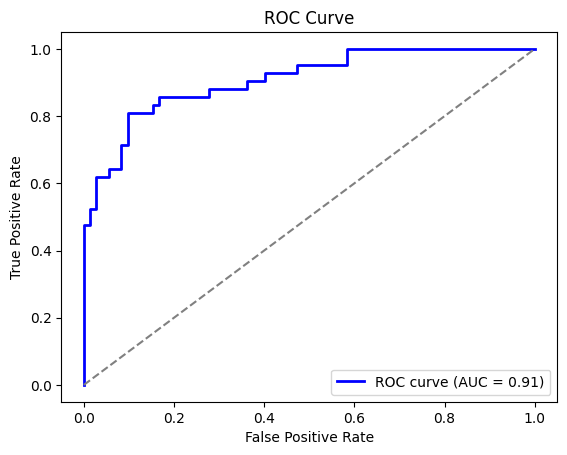

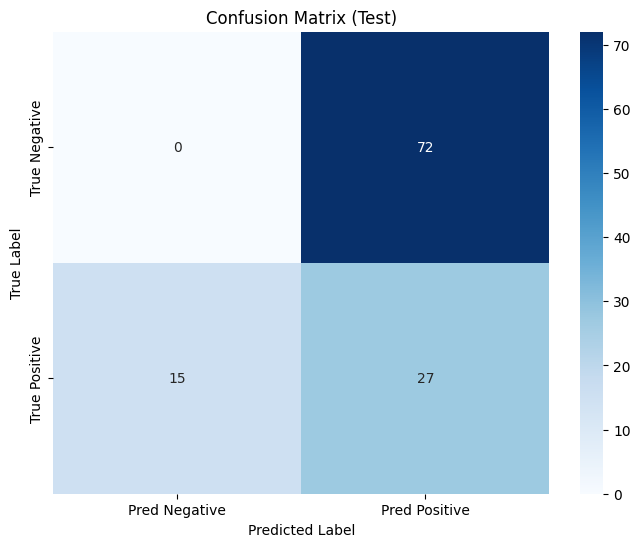

In [86]:
X = data.drop(columns=["Diagnosis", "ID"]) 
y = data["Diagnosis"] 
y_numeric = y.map({'B': 0, 'M': 1}) 


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42)


gamma = 1 
spectral_clustering = SpectralClustering(n_clusters=2, affinity='rbf', gamma=gamma, random_state=42)


M = 30
metrics_train = []
metrics_test = []

for _ in range(M):
    y_train_pred = spectral_clustering.fit_predict(X_train)
    y_test_pred = spectral_clustering.fit_predict(X_test)

    cluster_centers = []
    for i in range(2):
        cluster_points_train = X_train[y_train_pred == i]
        cluster_centers.append(np.mean(cluster_points_train, axis=0)) 
    

    distances_train = np.array([np.linalg.norm(X_train - center, axis=1) for center in cluster_centers]).T
    distances_test = np.array([np.linalg.norm(X_test - center, axis=1) for center in cluster_centers]).T
    

    probabilities_train = softmax(-distances_train, axis=1)[:, 1]  
    probabilities_test = softmax(-distances_test, axis=1)[:, 1] 

    auc_train = roc_auc_score(y_train, probabilities_train)
    auc_test = roc_auc_score(y_test, probabilities_test)

    metrics_train.append({
        "accuracy": accuracy_score(y_train, y_train_pred),
        "precision": precision_score(y_train, y_train_pred),
        "recall": recall_score(y_train, y_train_pred),
        "f1": f1_score(y_train, y_train_pred),
        "auc": auc_train,
    })
    
    metrics_test.append({
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "recall": recall_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),
        "auc": auc_test,
    })


avg_metrics_train = pd.DataFrame(metrics_train).mean()
avg_metrics_test = pd.DataFrame(metrics_test).mean()

print("Average Metrics (Train) after 30 runs:")
print(avg_metrics_train)

print("\nAverage Metrics (Test) after 30 runs:")
print(avg_metrics_test)


fpr, tpr, _ = roc_curve(y_test, probabilities_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], 
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#### (iv) Compare

By comparing the results, supervised learning outperforms both semi-supervised and unsupervised learning, achieving high scores across all metrics. In contrast, unsupervised learning underperforms compared to the others. This may be due to supervised learning having more labeled data available, allowing it to build a better model for learning and generalization.

## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [3]:
path = '/Users/apple/Desktop/data/data_banknote_authentication.txt'
columns2 = [
    "variance", "skewness", 
    "curtosis", "entropy", "class"
]

bank_data = pd.read_csv(path, header=None, sep=',', names=columns2)
#bank_data

bank_train_data = bank_data.sample(n=900, random_state=42)  
bank_test_data = bank_data.drop(bank_train_data.index) 

#bank_train_data
print(bank_test_data)



      variance  skewness  curtosis  entropy  class
1     4.545900   8.16740  -2.45860 -1.46210      0
4     0.329240  -4.45520   4.57180 -0.98880      0
8     3.203200   5.75880  -0.75345 -0.61251      0
11    3.989900  -2.70660   2.39460  0.86291      0
13   -1.576800  10.84300   2.54620 -2.93620      0
...        ...       ...       ...      ...    ...
1359  0.066129   2.49140  -2.94010 -0.62156      1
1363 -1.166700  -1.42370   2.92410  0.66119      1
1369 -3.750300 -13.45860  17.59320 -2.77710      1
1370 -3.563700  -8.38270  12.39300 -1.28230      1
1371 -2.541900  -0.65804   2.68420  1.19520      1

[472 rows x 5 columns]


### (b) Repeat each of the following two procedures 50 times

#### (i) Passive

In [5]:
X_train = bank_train_data.drop("class", axis=1).values
y_train = bank_train_data["class"].values
X_test = bank_test_data.drop("class", axis=1).values
y_test = bank_test_data["class"].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

penalty_range = np.logspace(-2, 2, 5)

passive_errors_df = pd.DataFrame(columns=range(1, 91),index=range(50)) 

for iteration in range(50):
    #print(f"Starting Iteration {iteration + 1}...")
    np.random.seed(iteration)  
    errors = []

    train_indices = np.random.choice(len(X_train), size=50, replace=False)

    while len(errors) < 90: 
        X_subset = X_train[train_indices]
        y_subset = y_train[train_indices]

        best_score = -np.inf
        best_model = None
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=iteration)

        for C in penalty_range:
            svm = LinearSVC(penalty="l1", dual=False, max_iter=100000, C=C)
            scores = cross_val_score(svm, X_subset, y_subset, cv=cv, scoring="accuracy")
            mean_score = scores.mean()
            if mean_score > best_score:
                best_score = mean_score
                best_model = svm

        best_model.fit(X_subset, y_subset)
        y_pred = best_model.predict(X_test)
        error = 1 - accuracy_score(y_test, y_pred)
        errors.append(error)

        remaining_indices = np.setdiff1d(np.arange(len(X_train)), train_indices)
        if len(remaining_indices) >= 10:
            additional_indices = np.random.choice(
                remaining_indices, size=10, replace=False
            )
            train_indices = np.concatenate([train_indices, additional_indices])
        elif len(remaining_indices) > 0:
            train_indices = np.concatenate([train_indices, remaining_indices])
        else:
           
            errors.extend([error] * (90 - len(errors)))


    passive_errors_df.loc[iteration] = errors

print("Final Error Rates DataFrame:")
print(passive_errors_df)
print(f"Shape of the DataFrame: {passive_errors_df.shape}")


passive_error=passive_errors_df

Starting Iteration 1...
Starting Iteration 2...
Starting Iteration 3...
Starting Iteration 4...
Starting Iteration 5...
Starting Iteration 6...
Starting Iteration 7...
Starting Iteration 8...
Starting Iteration 9...
Starting Iteration 10...
Starting Iteration 11...
Starting Iteration 12...
Starting Iteration 13...
Starting Iteration 14...
Starting Iteration 15...
Starting Iteration 16...
Starting Iteration 17...
Starting Iteration 18...
Starting Iteration 19...
Starting Iteration 20...
Starting Iteration 21...
Starting Iteration 22...
Starting Iteration 23...
Starting Iteration 24...
Starting Iteration 25...
Starting Iteration 26...
Starting Iteration 27...
Starting Iteration 28...
Starting Iteration 29...
Starting Iteration 30...
Starting Iteration 31...
Starting Iteration 32...
Starting Iteration 33...
Starting Iteration 34...
Starting Iteration 35...
Starting Iteration 36...
Starting Iteration 37...
Starting Iteration 38...
Starting Iteration 39...
Starting Iteration 40...
Starting 

#### (ii) Active

In [9]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=ConvergenceWarning)

X_train = bank_train_data.drop("class", axis=1).values
y_train = bank_train_data["class"].values
X_test = bank_test_data.drop("class", axis=1).values
y_test = bank_test_data["class"].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

penalty_range = np.logspace(-2, 2, 5)
n_iterations = 50
n_samples_per_iteration = 10
max_samples = 900


active_errors_df = pd.DataFrame(columns=range(1, max_samples // n_samples_per_iteration + 1), index=range(n_iterations))

for iteration in range(n_iterations):
    #print(f"Starting Iteration {iteration + 1}...")

    np.random.seed(iteration)

    pool_indices, _ = train_test_split(
        np.arange(len(X_train)),
        train_size=10,
        stratify=y_train,
        random_state=iteration,
    )
    X_pool = X_train[pool_indices]
    y_pool = y_train[pool_indices]
    #print(y_pool)

    errors = []

    while len(errors) < 90:
    
        if len(np.unique(y_pool)) < 2:
            additional_indices = np.random.choice(
                np.setdiff1d(np.arange(len(X_train)), pool_indices),
                size=10,
                replace=False,
            )
            pool_indices = np.concatenate([pool_indices, additional_indices])
            X_pool = X_train[pool_indices]
            y_pool = y_train[pool_indices]
            continue


        best_score = -np.inf
        best_model = None
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=iteration)

        for C in penalty_range:
            svm = LinearSVC(penalty="l1", dual=False, max_iter=10000, tol=1e-4, C=C)
            try:
                scores = cross_val_score(svm, X_pool, y_pool, cv=cv, scoring="accuracy")
                mean_score = scores.mean()
                if mean_score > best_score:
                    best_score = mean_score
                    best_model = svm
            except ValueError:
                continue

        if best_model is None:
            best_model = LinearSVC(penalty="l1", dual=False, max_iter=10000, tol=1e-4, C=1.0)

        best_model.fit(X_pool, y_pool)
        y_pred = best_model.predict(X_test)
        error = 1 - accuracy_score(y_test, y_pred)
        errors.append(error)

    
        distances = np.abs(best_model.decision_function(X_train))
        unselected_indices = np.setdiff1d(np.arange(len(X_train)), pool_indices)
        closest_indices = unselected_indices[np.argsort(distances[unselected_indices])[:10]]

        pool_indices = np.concatenate([pool_indices, closest_indices])
        X_pool = X_train[pool_indices]
        y_pool = y_train[pool_indices]

    active_errors_df.loc[iteration] = errors

print("Final Error Rates DataFrame:")
print(active_errors_df)
print(f"Shape of the DataFrame: {active_errors_df.shape}")

active_error=active_errors_df

Starting Iteration 1...
Starting Iteration 2...
Starting Iteration 3...
Starting Iteration 4...
Starting Iteration 5...
Starting Iteration 6...
Starting Iteration 7...
Starting Iteration 8...
Starting Iteration 9...
Starting Iteration 10...
Starting Iteration 11...
Starting Iteration 12...
Starting Iteration 13...
Starting Iteration 14...
Starting Iteration 15...
Starting Iteration 16...
Starting Iteration 17...
Starting Iteration 18...
Starting Iteration 19...
Starting Iteration 20...
Starting Iteration 21...
Starting Iteration 22...
Starting Iteration 23...
Starting Iteration 24...
Starting Iteration 25...
Starting Iteration 26...
Starting Iteration 27...
Starting Iteration 28...
Starting Iteration 29...
Starting Iteration 30...
Starting Iteration 31...
Starting Iteration 32...
Starting Iteration 33...
Starting Iteration 34...
Starting Iteration 35...
Starting Iteration 36...
Starting Iteration 37...
Starting Iteration 38...
Starting Iteration 39...
Starting Iteration 40...
Starting 

### (c) Average the 50 test errors

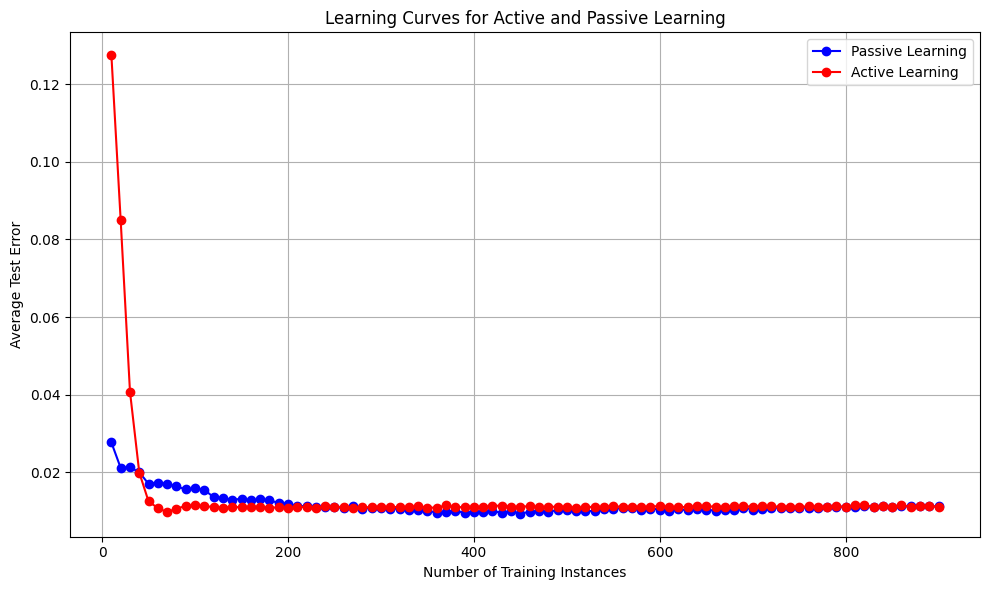

In [21]:
#print(passive_error)
#print(active_error)

passive_avg_errors = passive_error.mean(axis=0)
active_avg_errors = active_error.mean(axis=0)
#print(passive_avg_errors)


training_sizes = np.arange(10, 910, 10)

plt.figure(figsize=(10, 6))

plt.plot(training_sizes, passive_avg_errors, label='Passive Learning', color='blue', marker='o')
plt.plot(training_sizes, active_avg_errors, label='Active Learning', color='red', marker='o')

plt.title('Learning Curves for Active and Passive Learning')
plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()


### Reference
b.iii.A. https://stackoverflow.com/questions/63857914/what-does-it-mean-for-the-k-means-algorithm-to-be-trapped-in-a-local-minimum

b.iv i ask chatGpt "what is RBF kernel"<br>
chatgpt says:"The Radial Basis Function (RBF) kernel is a popular kernel function used in machine learning, particularly in Support Vector Machines (SVMs), for non-linear classification tasks. It's a type of non-linear kernel that allows the SVM to perform well on data that isn't linearly separable by mapping the input features into a higher-dimensional space.

How RBF Kernel Works:
The kernel computes the similarity between two points in the feature space based on their distance.
Points that are closer to each other will have a larger similarity score, while points that are far apart will have a smaller similarity score.
This enables the SVM to create decision boundaries that are non-linear and can adapt to complex data structures.
Benefits of the RBF Kernel:
Non-linear decision boundaries: It can map input data into a higher-dimensional space where linear separation is possible, even if the original data is not linearly separable.
Flexible: The RBF kernel can handle a wide variety of datasets and is particularly good at learning complex decision boundaries.
Well-suited for high-dimensional data: It's commonly used in scenarios where the data has many features.
When to Use the RBF Kernel:
Non-linearly separable data: If your data cannot be separated by a straight line or hyperplane, the RBF kernel can help by projecting the data into a higher-dimensional space.
When you're unsure of the decision boundary: The RBF kernel is very effective when the relationship between the input features and the target is complex and not easily captured by linear models.
Choosing the Right Parameters:
𝛾
γ (or 
𝜎
σ): This parameter controls the shape of the decision boundary. A small 
𝛾
γ creates a smoother boundary, while a large 
𝛾
γ leads to a more complex decision boundary that might overfit the data.
A small 
𝛾
γ leads to a smoother, more generalized decision boundary.
A large 
𝛾
γ results in a decision boundary that may fit the noise in the data.
C: The regularization parameter, which controls the trade-off between a high-margin hyperplane and low misclassification errors. A larger 
𝐶
C tries to fit the data better, but it might lead to overfitting.
How to Use RBF Kernel in SVM:
In Python's scikit-learn, the SVC class supports the RBF kernel. You can use it as follows:

python
Copy code
from sklearn.svm import SVC

Create an SVM classifier with the RBF kernel
svm_rbf = SVC(kernel='rbf', gamma='scale', C=1.0)

Fit the model to the training data
svm_rbf.fit(X_train, y_train)

 Predict on the test data
y_pred = svm_rbf.predict(X_test)

Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
In this example:

kernel='rbf' specifies that the RBF kernel is being used.
gamma='scale' automatically sets the 
𝛾
γ value to 
1
/
(
𝑛
features
×
X.var()
)
1/(n 
features
​
 ×X.var()), which is often a good starting point.
C=1.0 is the regularization parameter, controlling the margin width.
You can experiment with different values of 
𝛾
γ and C to fine-tune the SVM's performance.

Let me know if you need further clarification on this!"